## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset= nlp.load_dataset('emotion')

In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train=dataset['train']
val= dataset['validation']
test= dataset['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets, labels=get_tweet(train)

In [ ]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer= Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

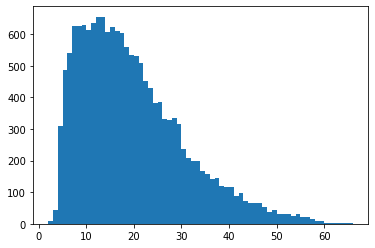

In [ ]:
lengths=[len(t.split(' '))for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq= get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes=set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

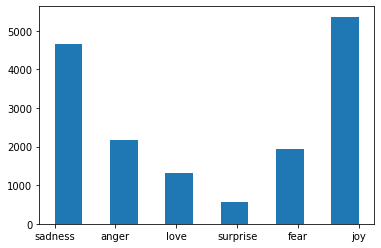

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
class_to_index=dict((c,i) for i ,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'love': 0, 'surprise': 1, 'sadness': 2, 'joy': 3, 'fear': 4, 'anger': 5}

In [ ]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'sadness', 3: 'joy', 4: 'fear', 5: 'anger'}

In [ ]:
names_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels)
print(train_labels[0])

2


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation="softmax")
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels= get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels= names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [ ]:
h= model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='validation_accuracy', patience=2)
    ]

)

Epoch 1/20
497/500 [============================>.] - ETA: 0s - loss: 1.2976 - accuracy: 0.4960

500/500 [==============================] - 17s 17ms/step - loss: 1.2944 - accuracy: 0.4974 - val_loss: 0.8440 - val_accuracy: 0.6995
Epoch 2/20
498/500 [============================>.] - ETA: 0s - loss: 0.6099 - accuracy: 0.7733

500/500 [==============================] - 6s 13ms/step - loss: 0.6096 - accuracy: 0.7734 - val_loss: 0.6253 - val_accuracy: 0.7725
Epoch 3/20
499/500 [============================>.] - ETA: 0s - loss: 0.3601 - accuracy: 0.8792

500/500 [==============================] - 7s 14ms/step - loss: 0.3602 - accuracy: 0.8792 - val_loss: 0.4881 - val_accuracy: 0.8360
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9237

500/500 [==============================] - 7s 14ms/step - loss: 0.2394 - accuracy: 0.9237 - val_loss: 0.4393 - val_accuracy: 0.8660
Epoch 5/20
497/500 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9422

500/500 [==============================] - 6s 13ms/step - loss: 0.1782 - accuracy: 0.9423 - val_loss: 0.4159 - val_accuracy: 0.8810
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9551

500/500 [==============================] - 7s 14ms/step - loss: 0.1395 - accuracy: 0.9551 - val_loss: 0.4482 - val_accuracy: 0.8635
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9671

500/500 [==============================] - 6s 13ms/step - loss: 0.1077 - accuracy: 0.9671 - val_loss: 0.4315 - val_accuracy: 0.8735
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9704

500/500 [==============================] - 6s 13ms/step - loss: 0.0891 - accuracy: 0.9704 - val_loss: 0.4458 - val_accuracy: 0.8795
Epoch 9/20
497/500 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9740

500/500 [==============================] - 6s 13ms/step - loss: 0.0803 - accuracy: 0.9741 - val_loss: 0.4486 - val_accuracy: 0.8860
Epoch 10/20
498/500 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9766

500/500 [==============================] - 6s 13ms/step - loss: 0.0754 - accuracy: 0.9765 - val_loss: 0.4661 - val_accuracy: 0.8820
Epoch 11/20
499/500 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9817

500/500 [==============================] - 7s 14ms/step - loss: 0.0590 - accuracy: 0.9816 - val_loss: 0.4577 - val_accuracy: 0.8905
Epoch 12/20
499/500 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9815

500/500 [==============================] - 7s 13ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.4164 - val_accuracy: 0.8885
Epoch 13/20
498/500 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9824

500/500 [==============================] - 7s 13ms/step - loss: 0.0577 - accuracy: 0.9824 - val_loss: 0.3960 - val_accuracy: 0.8935
Epoch 14/20
496/500 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9873

500/500 [==============================] - 6s 13ms/step - loss: 0.0418 - accuracy: 0.9874 - val_loss: 0.4272 - val_accuracy: 0.9005
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9869

500/500 [==============================] - 7s 15ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.3827 - val_accuracy: 0.9010
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9893

500/500 [==============================] - 12s 24ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.4373 - val_accuracy: 0.9020
Epoch 17/20
499/500 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9912

500/500 [==============================] - 6s 13ms/step - loss: 0.0265 - accuracy: 0.9912 - val_loss: 0.4917 - val_accuracy: 0.9025
Epoch 18/20
498/500 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9900

500/500 [==============================] - 6s 13ms/step - loss: 0.0286 - accuracy: 0.9900 - val_loss: 0.4532 - val_accuracy: 0.9000
Epoch 19/20
497/500 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9874

500/500 [==============================] - 7s 14ms/step - loss: 0.0385 - accuracy: 0.9874 - val_loss: 0.4231 - val_accuracy: 0.8970
Epoch 20/20
498/500 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9898

500/500 [==============================] - 6s 13ms/step - loss: 0.0262 - accuracy: 0.9898 - val_loss: 0.4576 - val_accuracy: 0.8950


## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

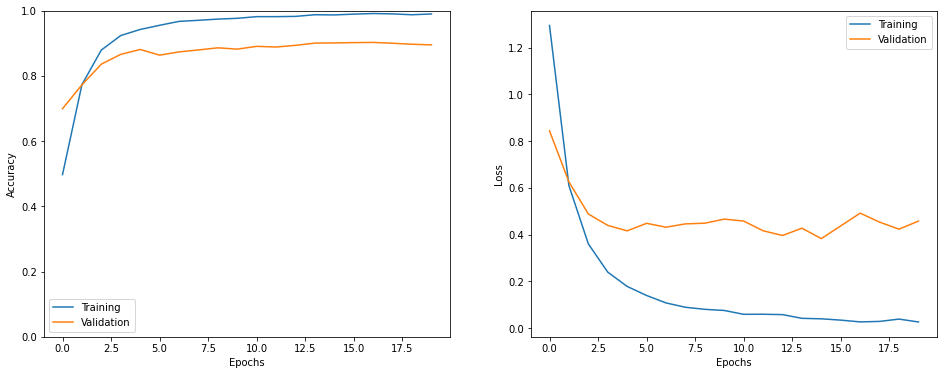

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels= get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels= names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4486 - accuracy: 0.8925


In [ ]:
i = random.randint(0,len(test_labels)-1)
print('Sentence : ', test_tweets[i])
print('Emotion : ', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0] #made the test input an approriate shape that is just one example
pred_class= index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion : ', pred_class)

Sentence :  im not feeling anything suspicious really
Emotion :  fear
1/1 [==============================] - 0s 20ms/step
Predicted Emotion :  fear


In [ ]:
preds_= model.predict(test_seq)
preds= np.argmax(preds_, axis=1)

63/63 [==============================] - 0s 8ms/step


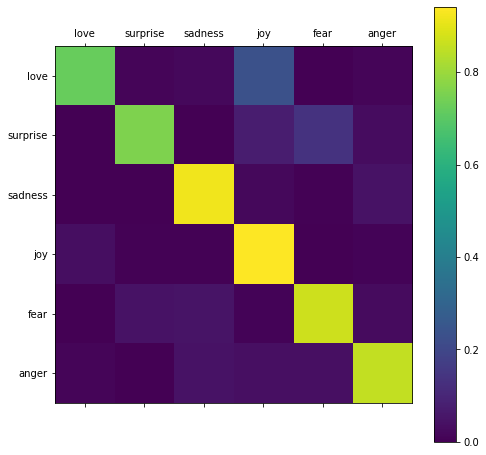

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))